In [1]:
import yfinance as yf
import pandas as pd
from darts import TimeSeries
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.random_forest import RandomForest
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, TFTModel, NBEATSModel, LinearRegressionModel, TransformerModel
from darts.metrics import mape, mae, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from darts.utils.model_selection import train_test_split
import darts.utils.statistics as darts_stats

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()

    market_data = yf.download((' ').join(tickers), start="2015-01-01", end="2020-01-01", group_by = 'ticker')

    # returns = pd.DataFrame()

    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.pct_change().dropna()

    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data

In [3]:
data = load_data()

for i, j in itertools.product(range(0, len(data), data.nunique().Ticker), range(6)):
    data.loc[i+j, 'Date'] = i and int(i / 6) or 0

data.Date = data.Date.astype('int')

data = data[data.Ticker == 'GOOGL']

data

[*********************100%***********************]  6 of 6 completed


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
3,0,GOOGL,26.477501,26.477501,26.790001,26.393999,26.629999,26480000
9,1,GOOGL,25.973000,25.973000,26.399500,25.887501,26.357500,41182000
15,2,GOOGL,25.332001,25.332001,26.060499,25.277500,26.025000,54456000
21,3,GOOGL,25.257500,25.257500,25.574499,25.182501,25.547501,46918000
27,4,GOOGL,25.345501,25.345501,25.375000,24.750999,25.075500,73054000
...,...,...,...,...,...,...,...,...
7521,1253,GOOGL,67.221497,67.221497,67.600502,67.208504,67.510498,13468000
7527,1254,GOOGL,68.123497,68.123497,68.160004,67.275497,67.327499,23662000
7533,1255,GOOGL,67.732002,67.732002,68.352501,67.650002,68.199997,23212000
7539,1256,GOOGL,66.985497,66.985497,67.849998,66.891998,67.840500,19994000


<AxesSubplot: >

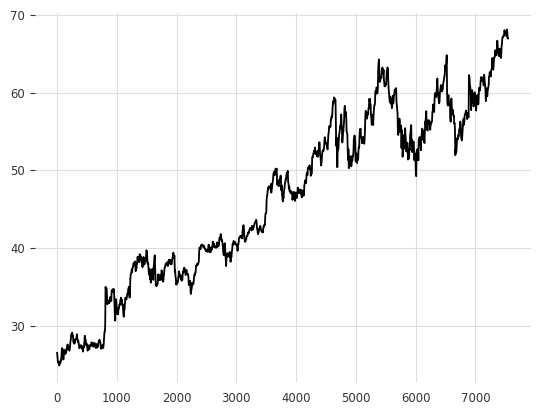

In [4]:
data.Close.plot()

In [5]:
data = TimeSeries.from_dataframe(
    data, time_col='Date', 
    value_cols=['Adj Close', 'Close', 'High', 'Low', 'Open','Volume'],
    fill_missing_dates=True,
    freq='D',
    static_covariates=None
    )

In [6]:
missing_values_ratio(data)

0.0

In [7]:
train, val = train_test_split(
    data,
    vertical_split_type='model-aware',
    test_size=0.15,
    input_size=10,
    horizon=5
    )

In [ ]:
darts_stats.check_seasonality(train['Volume'])

In [ ]:
darts_stats.plot_residuals_analysis(train['Volume'])

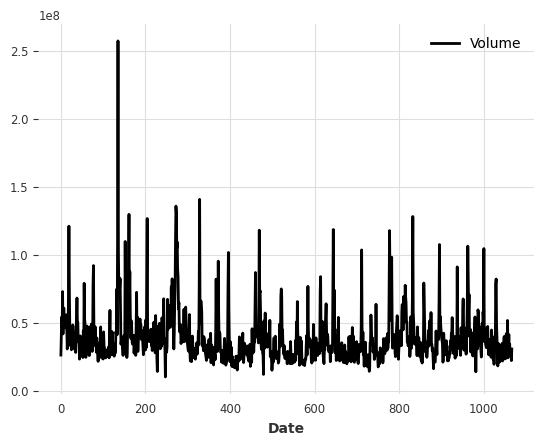

In [8]:
train['Volume'].plot()

In [9]:
scaler = Scaler(StandardScaler())

In [10]:
target = 'Close'

train_scaled = scaler.fit_transform(train)
train_cov = train_scaled[['Adj Close', 'High', 'Low', 'Open']]

val_scaled = scaler.transform(val)
val_cov = val_scaled[['Adj Close', 'High', 'Low', 'Open']]

series = scaler.transform(data)
series_cov = series[['Adj Close', 'High', 'Low', 'Open']]

In [ ]:
def plot_backtest(model, start=900, horizon=3, stride=1, train_length=20):
    backtest_series = model.historical_forecasts(
    series=series['Close'],
    past_covariates=series_cov,
    start=start,
    forecast_horizon=horizon,
    retrain=False,
    verbose=False,
    stride=stride,
    train_length=train_length
    )

    plt.figure(figsize=(8, 5))
    (series)['Close'][start:].plot(label="actual")
    (backtest_series)['Close'].plot(label="backtest")
    # scaler.inverse_transform(series)['Close'].shift(horizon)[start:].plot(label="shifted")
    plt.legend()
    mape_loss = mape((series['Close']), (backtest_series))
    plt.title(f"Backtest, starting day {start} with horizon {horizon} - mape {mape_loss:.2f} %")

## RNN

In [11]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=1e-4,
    mode='min',
)

model = BlockRNNModel(
    input_chunk_length=20,
    output_chunk_length=5,
    model='LSTM',
    n_epochs=100,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": -1,
      "callbacks": [my_stopper],
      "enable_progress_bar": True
    }
)

model.fit(
    series=train_scaled[target],
    past_covariates=train_cov,
    val_series=val_scaled[target],
    val_past_covariates=val_cov
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | fc            | Sequential       | 130   
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [12]:
backtest_series = model.historical_forecasts(
    series=series['Close'],
    past_covariates=series_cov,
    start=1067,
    forecast_horizon=5,
    retrain=False,
    verbose=False,
    stride=5,
    train_length=25,
    last_points_only=False
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 33it [00:00, ?it/s]

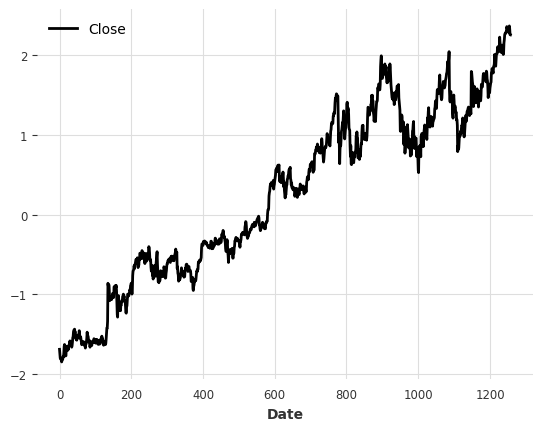

In [18]:
series['Close'].plot()

In [19]:
for i in backtest_series:
    print(i)

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[1.4444953 ]],

       [[1.42492416]],

       [[1.42232732]],

       [[1.40401629]],

       [[1.39489694]]])
Coordinates:
  * Date       (Date) int64 1067 1068 1069 1070 1071
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[1.60266948]],

       [[1.59669566]],

       [[1.56151942]],

       [[1.54952931]],

       [[1.5397901 ]]])
Coordinates:
  * Date       (Date) int64 1072 1073 1074 1075 1076
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[1.61250103]],

       [[1.60310192]],

       [[1.56571178]],

       [[1.55675606]],

       [[1.54652029]]])
Coordinates:
  * Date     

In [ ]:
plot_backtest(
    model=model,
    start=1220,
    horizon=1,
    stride=1,
    train_length=25
)

In [ ]:
pred = model.historical_forecasts(
    series=series[target],
    past_covariates=series_cov,
    forecast_horizon=5,
    stride=1,
    retrain=False
)

In [ ]:
pred.plot()
val_scaled[target].plot()

In [ ]:
pred = model.predict(
    n=5, series=train_scaled[target],
    past_covariates=train_cov
)

In [ ]:
pred.plot()
val_scaled[target][18:26].plot()

## N BEATS

In [ ]:
model = TransformerModel(
    input_chunk_length=3,
    output_chunk_length=5,
    # d_model=5,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": -1,
      "callbacks": [my_stopper],
      "enable_progress_bar": True
    }
)

In [ ]:
model.fit(
    train_scaled[target],
    past_covariates=train_cov,
    val_series=val_scaled[target],
    val_past_covariates=val_cov
)